In [54]:
from pathlib import Path
import pickle

import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, AllChem, RDKFingerprint, MACCSkeys
from rdkit.Chem.AtomPairs import Pairs, Torsions

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.stats import randint

from NegativeClassOptimization import ml, visualisations

In [55]:
import catboost #install this

In [56]:
targets_balanced_list = ['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309']
tasks = ['vs_Weak', 'vs_Non-binder', 'vs_all', 'shuffled_weak']

Testing new encoding

In [57]:
#test parameters
#target = 'P06239'
target = 'P11309'
split = 42
train_task = 'vs_Weak'

In [58]:
path_to_target = Path('./data/KIBA_selected/old_to_delete/processed_old') / target
path_vs_task_split = path_to_target / train_task / f'split_{split}'
path_to_test = path_vs_task_split / 'train.pkl'
train_dataset = pd.read_pickle(path_to_test)


In [59]:
smiles = train_dataset.Drug.iloc[1]

In [ ]:
#Morgan fingerprint. See how to choose it? 
radius=3 #3
fpSize=1024 #2048

In [ ]:
mol = Chem.MolFromSmiles(smiles)

# Generate Morgan fingerprint (ECFP4) with 1024 bits
#fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpSize)
fp = mfpgen.GetFingerprint(mol)
# Convert to a numpy array (optional)
fp_array = np.array(fp)

print(fp_array)

[0 0 0 ... 0 0 0]


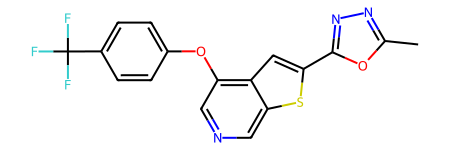

In [ ]:
mol

In [ ]:
np.array(RDKFingerprint(mol))

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
def ECFP4_enc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=1024)
    fp = mfpgen.GetFingerprint(mol)
    #fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return np.array(fp)

In [ ]:
def topo_fing_enc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = RDKFingerprint(mol)
    return np.array(fp)

In [ ]:
def MACCSkeys_enc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(fp)

In [ ]:
#try different encodings and see which one is better
train_dataset['ECFP4'] = train_dataset.Drug.apply(ECFP4_enc)
train_dataset['topo_fing'] = train_dataset.Drug.apply(topo_fing_enc)
train_dataset['MACCSkeys'] = train_dataset.Drug.apply(MACCSkeys_enc)

In [14]:
for enc in ['ECFP4','MACCSkeys','topo_fing']: #'topo_fing', 'AtomPair' ['ECFP4','MACCSkeys','topo_fing', 'Torsions', 'Pairs']
    #I need a corresponding size of the fingerprint
    X = train_dataset[enc]
    n_enc = len(X[0])
    columns = [f'bit_{i}' for i in range(n_enc)]
    X_df = pd.DataFrame(X.to_list(), index=X.index, columns=columns)
    y = train_dataset["Y_binary"]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

    model = catboost.CatBoostClassifier(
        iterations=500,
        learning_rate=0.001,
        loss_function='Logloss',
        eval_metric='Accuracy',
        random_seed=42,
        l2_leaf_reg=3,
        bagging_temperature=1,
        random_strength=1,
        verbose=False
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    print(enc, model.best_score_)
    


ECFP4 {'learn': {'Accuracy': 0.8758782201405152, 'Logloss': 0.631661818832683}, 'validation': {'Accuracy': 0.6261682242990654, 'Logloss': 0.683683890058948}}
MACCSkeys {'learn': {'Accuracy': 0.8758782201405152, 'Logloss': 0.6271842414423097}, 'validation': {'Accuracy': 0.5700934579439252, 'Logloss': 0.691637082700374}}
topo_fing {'learn': {'Accuracy': 0.9484777517564403, 'Logloss': 0.5671348872657289}, 'validation': {'Accuracy': 0.5981308411214953, 'Logloss': 0.6855763337942812}}


In [ ]:
# train cat boost for all targets?

In [21]:
#!pip install boto3 requests regex sentencepiece sacremoses
#!pip install transformers

Try ChemBert embedding

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer

/opt/homebrew/anaconda3/envs/nco/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import clear_output as clr

In [3]:
chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
chemberta.eval()
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls.numpy(), embeddings_mean.numpy()

In [122]:
train_mean_pad_true.shape

(534, 600)

In [16]:
""""train_dataset['ChemBERTa_cls'] = list(train_cls_pad_true)
train_dataset['ChemBERTa_mean'] = list(train_mean_pad_true)
for enc in ['ChemBERTa_cls']: #'topo_fing', 'AtomPair' ['ECFP4','MACCSkeys','topo_fing', 'Torsions', 'Pairs']
    #I need a corresponding size of the fingerprint
    X = train_dataset[enc]
    n_enc = len(X[0])
    columns = [f'bit_{i}' for i in range(n_enc)]
    X_df = pd.DataFrame(X.to_list(), index=X.index, columns=columns)
    y = train_dataset["Y_binary"]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

    model = catboost.CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        loss_function='CrossEntropy',
        eval_metric='Accuracy',
        random_seed=42,
        l2_leaf_reg=3,
        bagging_temperature=1,
        random_strength=1,
        verbose=False
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    print(enc, model.best_score_)""""

ChemBERTa_cls {'learn': {'Accuracy': 1.0, 'CrossEntropy': 0.21727192751826574}, 'validation': {'Accuracy': 0.6635514018691588, 'CrossEntropy': 0.6378422289290548}}


In [9]:
def chembert_encode(df, SMILE_col):
    X_cls_pad_true, X_mean_pad_true = featurize_ChemBERTa(df[SMILE_col])
    #return X_cls_pad_true.detach().cpu().numpy()
    return X_cls_pad_true

In [8]:
def train_catboost_by_task(task, target, split, save_model=False):
    path_to_target = Path('./data/KIBA_selected/processed') / target
    path_vs_task_split = path_to_target / task / f'split_{split}'

    # Loading data
    path_to_train = path_vs_task_split / 'train.pkl'
    train_df = pd.read_pickle(path_to_train)

    X = chembert_encode(train_df, 'Drug')
    y = train_df["Y_binary"]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = catboost.CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        loss_function='CrossEntropy',
        eval_metric='Accuracy',
        random_seed=42,
        l2_leaf_reg=3,
        bagging_temperature=1,
        random_strength=1,
        verbose=False
        )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    # save best model
    if save_model:
        model.save_model(path_vs_task_split / 'catboost_model.cbm')

    return model

In [ ]:
tasks_opt = ['vs_weak', 'shuffled_weak', 'vs_non_binder', 'shuffled_non_binder', 'vs_all', 'shuffled_all']

perf_list = []
for target in tqdm(targets_balanced_list, desc="Targets"):
    for split in tqdm([0,1,2,42], desc="Splits"):
        for task in tqdm(tasks_opt, desc="Tasks"):
            acc_test = train_catboost_by_task(task, target, split, save_model=True)
            perf_list.append([target, split, task, acc_test])

In [75]:
df_closed = pd.DataFrame(perf_list, columns=["target", "split", "train_task", "accuracy"])

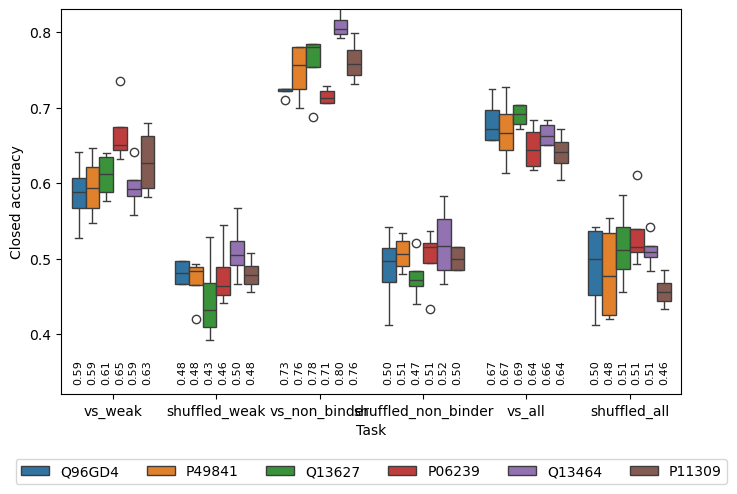

In [77]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_closed, x="train_task", y="accuracy", hue="target", order=tasks_opt, ax=ax)
plt.ylim(0.32,0.83)
visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)
ax.set_ylabel("Closed accuracy")
ax.set_xlabel("Task")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=6)

In [81]:
records = []
for target in tqdm(targets_balanced_list, desc="Targets"):
    for split in tqdm([0,1,2,42], desc="Splits"):
        for train_task in tqdm(tasks_opt, desc="Train tasks"):
            path_model = Path('./data/KIBA_selected/processed')  / target / train_task / f'split_{split}' / 'catboost_model.cbm'
            model = catboost.CatBoostClassifier()
            model.load_model(path_model)

            for test_task in tqdm(tasks_opt, desc="Test tasks"):
                path_to_target = Path('./data/KIBA_selected/processed')  / target
                path_vs_task_split = path_to_target / test_task / f'split_{split}'
                path_to_test = path_vs_task_split / 'test.pkl'
                test_dataset = pd.read_pickle(path_to_test)
                
                X_test = catboost_dataset(test_dataset)
                y_test = test_dataset["Y_binary"]
                
                y_pred = model.predict(X_test)
                acc_test = accuracy_score(y_test, y_pred)

                records.append([target, train_task, test_task, split, acc_test])
                




Targets:   0%|          | 0/6 [00:00<?, ?it/s]

















100%|██████████| 131/131 [00:00<00:00, 313.98it/s]

















100%|██████████| 131/131 [00:00<00:00, 319.28it/s]














100%|██████████| 131/131 [00:00<00:00, 338.84it/s]














100%|██████████| 131/131 [00:00<00:00, 275.41it/s]














100%|██████████| 131/131 [00:00<00:00, 320.47it/s]

















100%|██████████| 131/131 [00:00<00:00, 307.63it/s]


Test tasks: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


















100%|██████████| 131/131 [00:00<00:00, 261.97it/s]














100%|██████████| 131/131 [00:00<00:00, 327.97it/s]














100%|██████████| 131/131 [00:00<00:00, 273.41it/s]




















100%|██████████| 131/131 [00:00<00:00, 197.64it/s]














100%|██████████| 131/131 [00:00<00:00, 309.08it/s]




















100%|██████████| 131/131 [00:00<00:00, 235.08it/s]


Test tasks: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


















100%|█████

In [82]:
de_perf_all = pd.DataFrame(records, columns=["target", "train_task", "test_task", "split", "accuracy"])

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_80076/3041299091.py:10: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


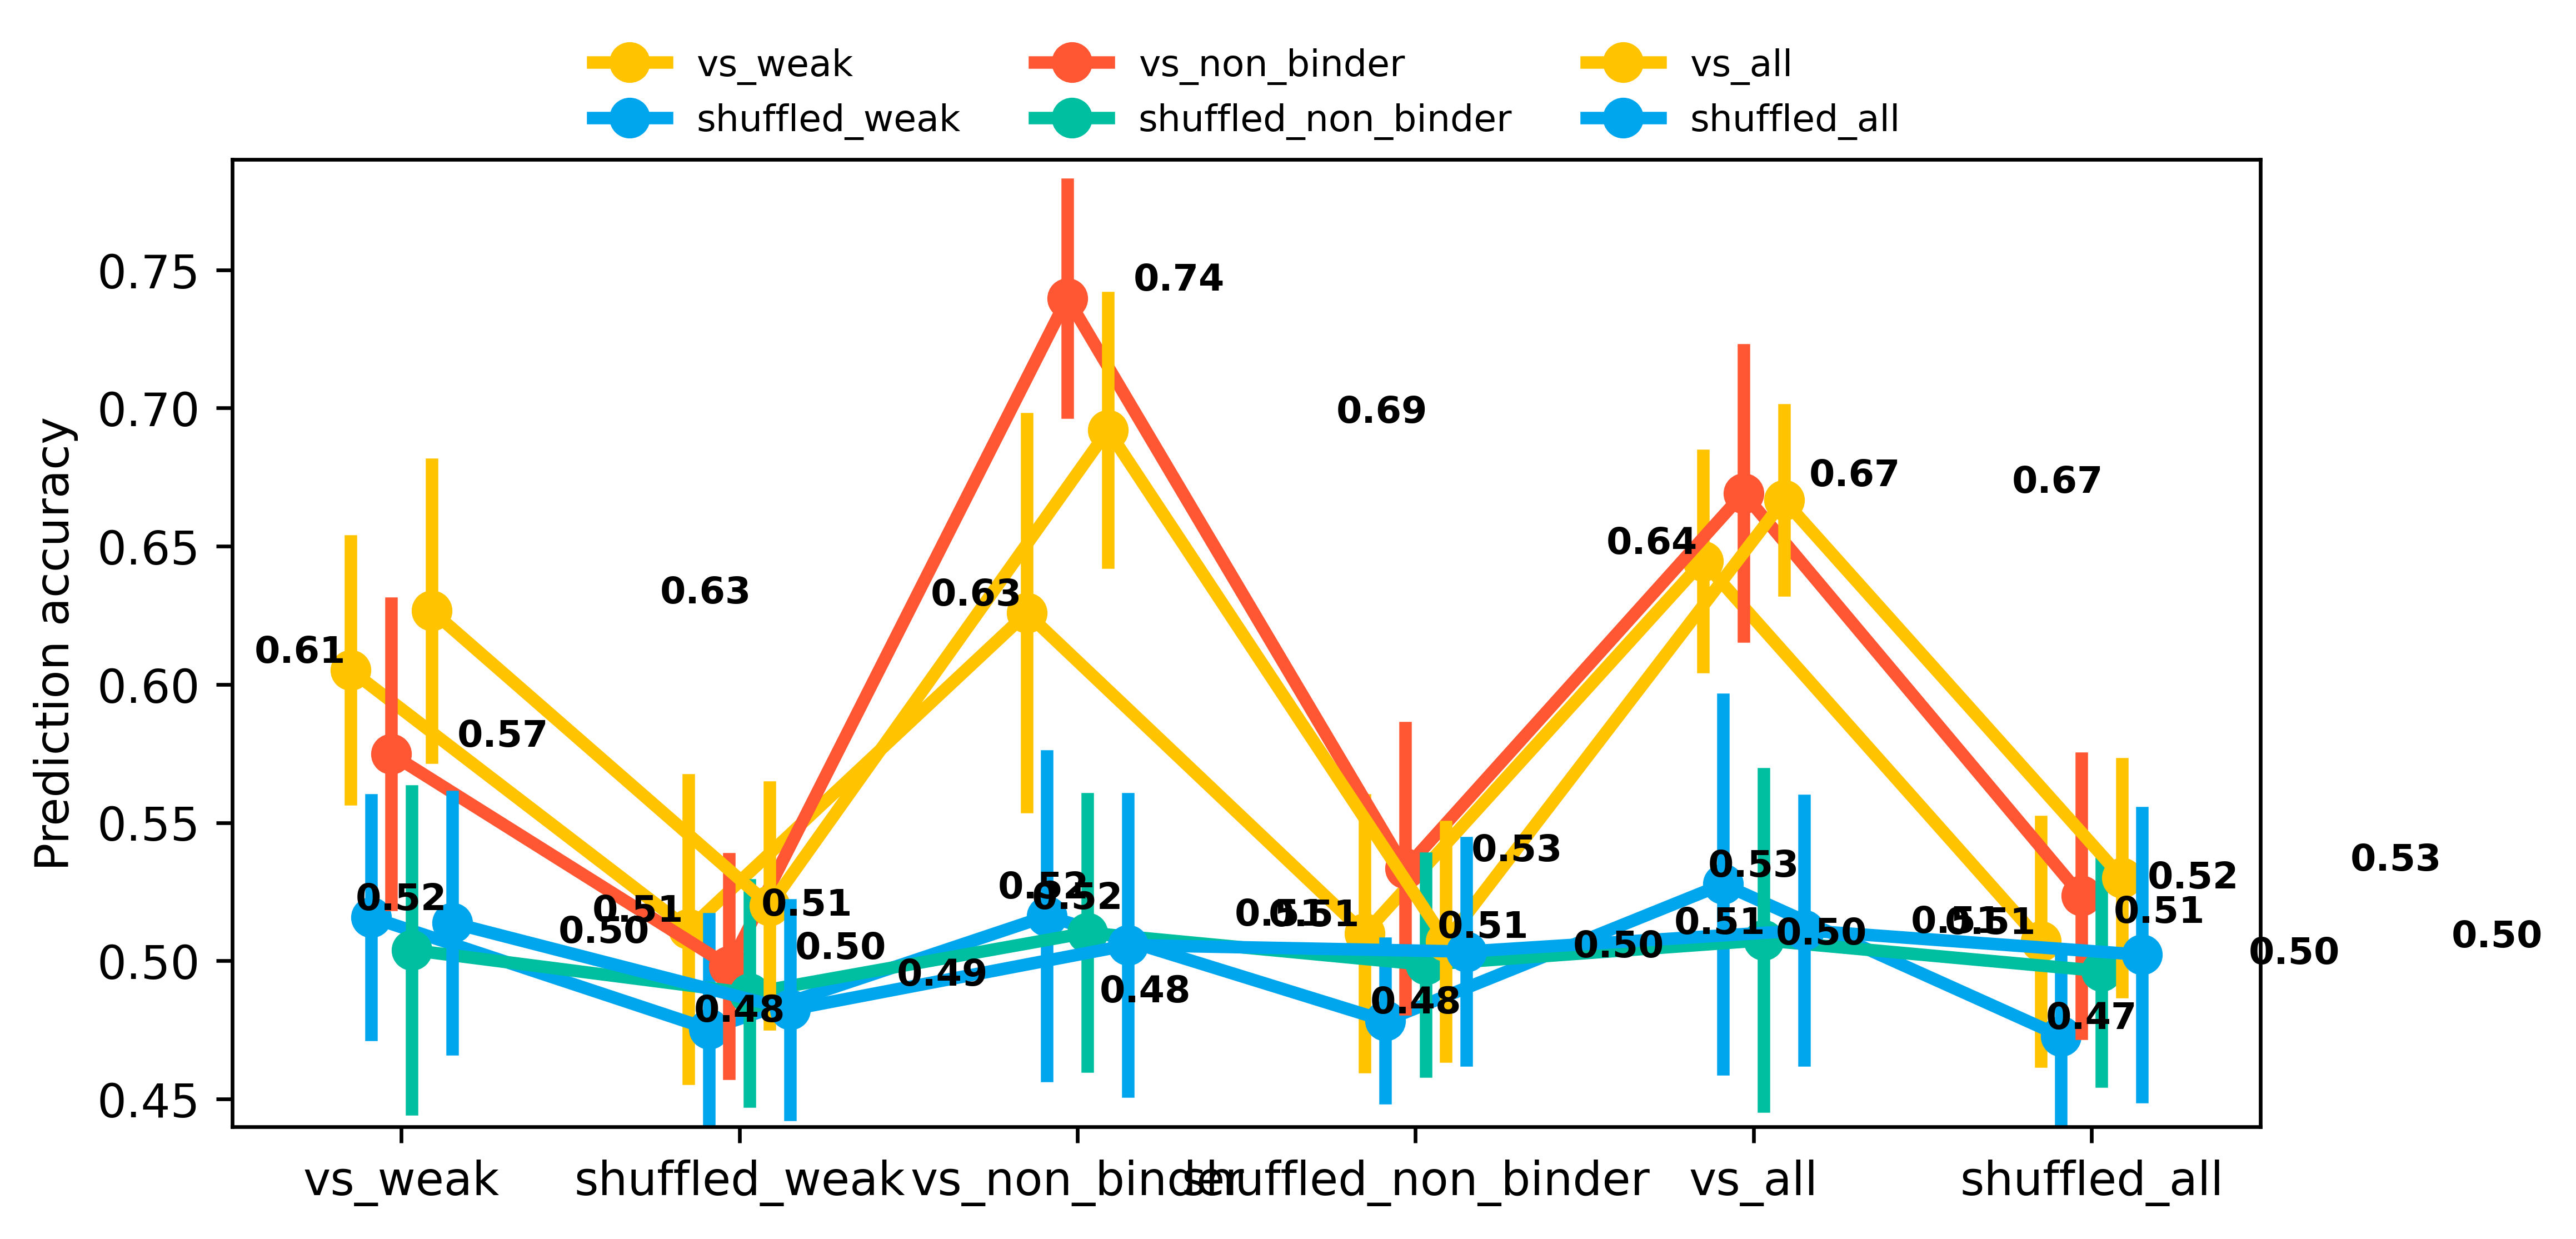

In [98]:
#now I need to plot openset performance
#improve colors
#and make numbers numbers

plt.rcParams['svg.fonttype'] = 'none'
colors = ['#FFC300','#00A6ED', '#FF5733','#00BFA0']


fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    de_perf_all,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
    palette=colors,
    estimator = "median"

)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.set_ylim(0.44, 0.79)

# Add text mediam values
# Add text median values
medians = de_perf_all.groupby(['test_task', 'train_task'])['accuracy'].median().reset_index()
for i, row in medians.iterrows():
    test_task = row['test_task']
    train_task = row['train_task']
    median_val = row['accuracy']
    x = ax.get_xticks()[list(de_perf_all['test_task'].unique()).index(test_task)]
    hue_offset = list(de_perf_all['train_task'].unique()).index(train_task) * 0.3 - 0.3
    ax.text(
        x + hue_offset,
        median_val,
        f"{median_val:.2f}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=8,
        fontweight="bold",
    )

fig.savefig('./figures/small_molec_ood.svg')



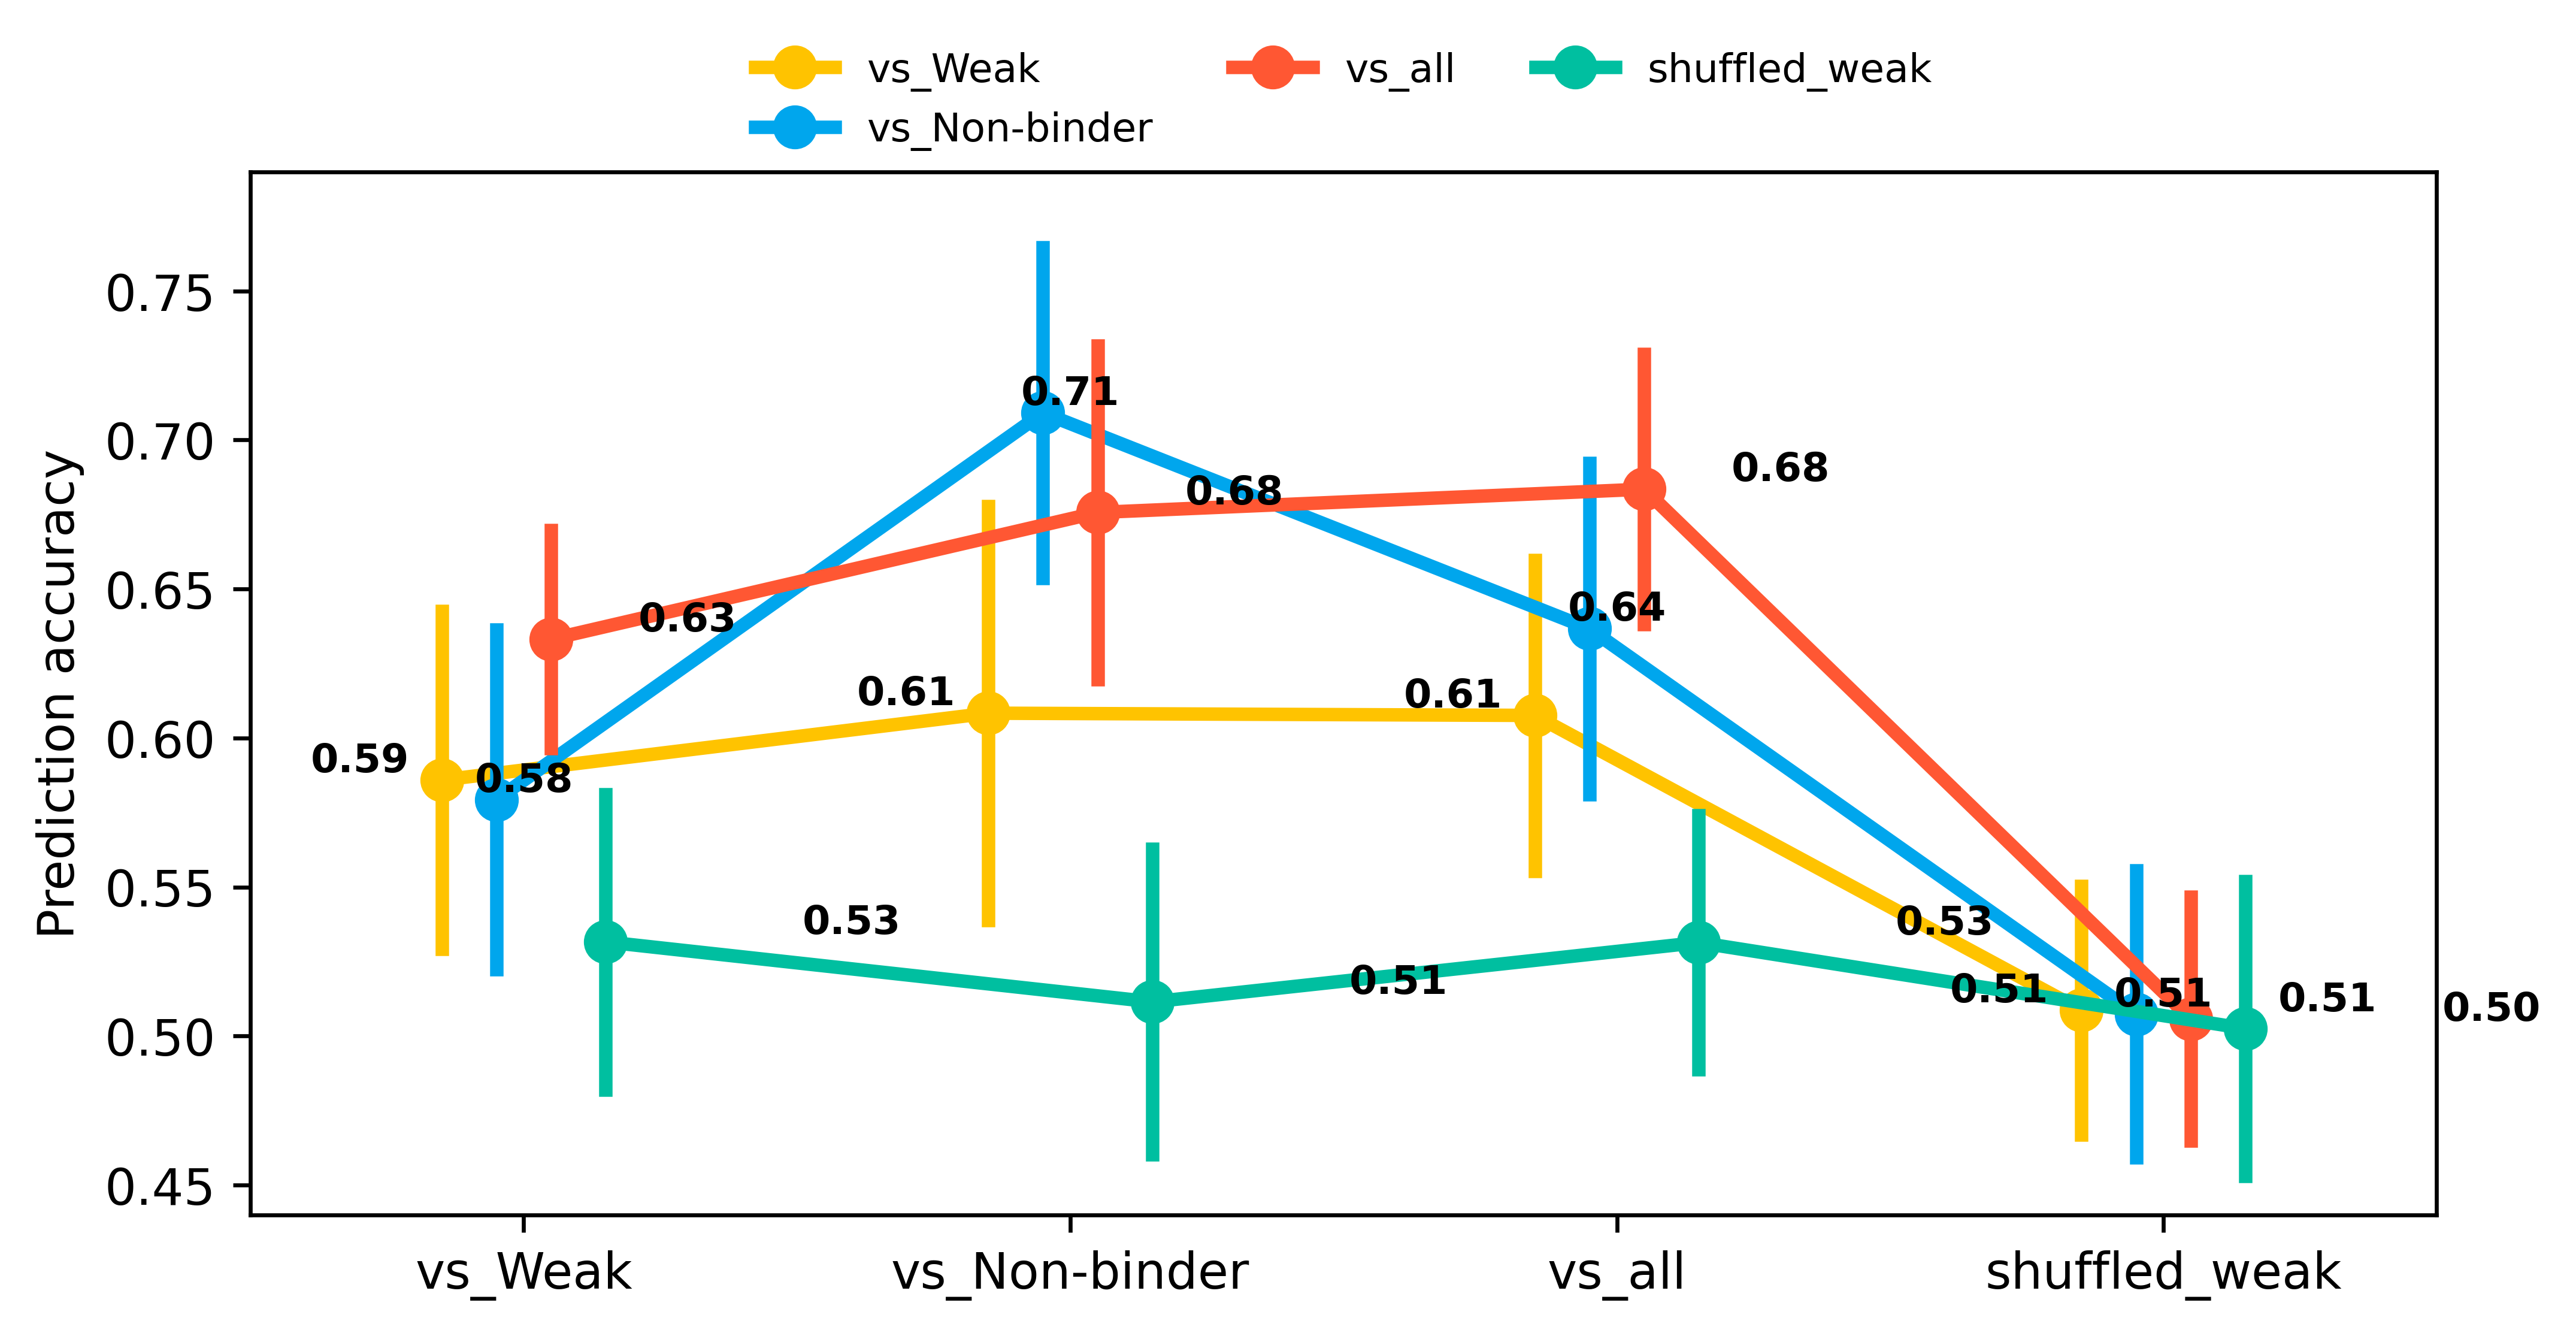

In [39]:
#now I need to plot openset performance
#improve colors
#and make numbers numbers

plt.rcParams['svg.fonttype'] = 'none'
colors = ['#FFC300','#00A6ED', '#FF5733','#00BFA0']


fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    de_perf_all,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
    palette=colors,
    estimator = "median"

)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.set_ylim(0.44, 0.79)

# Add text mediam values
# Add text median values
medians = de_perf_all.groupby(['test_task', 'train_task'])['accuracy'].median().reset_index()
for i, row in medians.iterrows():
    test_task = row['test_task']
    train_task = row['train_task']
    median_val = row['accuracy']
    x = ax.get_xticks()[list(de_perf_all['test_task'].unique()).index(test_task)]
    hue_offset = list(de_perf_all['train_task'].unique()).index(train_task) * 0.3 - 0.3
    ax.text(
        x + hue_offset,
        median_val,
        f"{median_val:.2f}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=8,
        fontweight="bold",
    )

fig.savefig('./figures/small_molec_ood.svg')



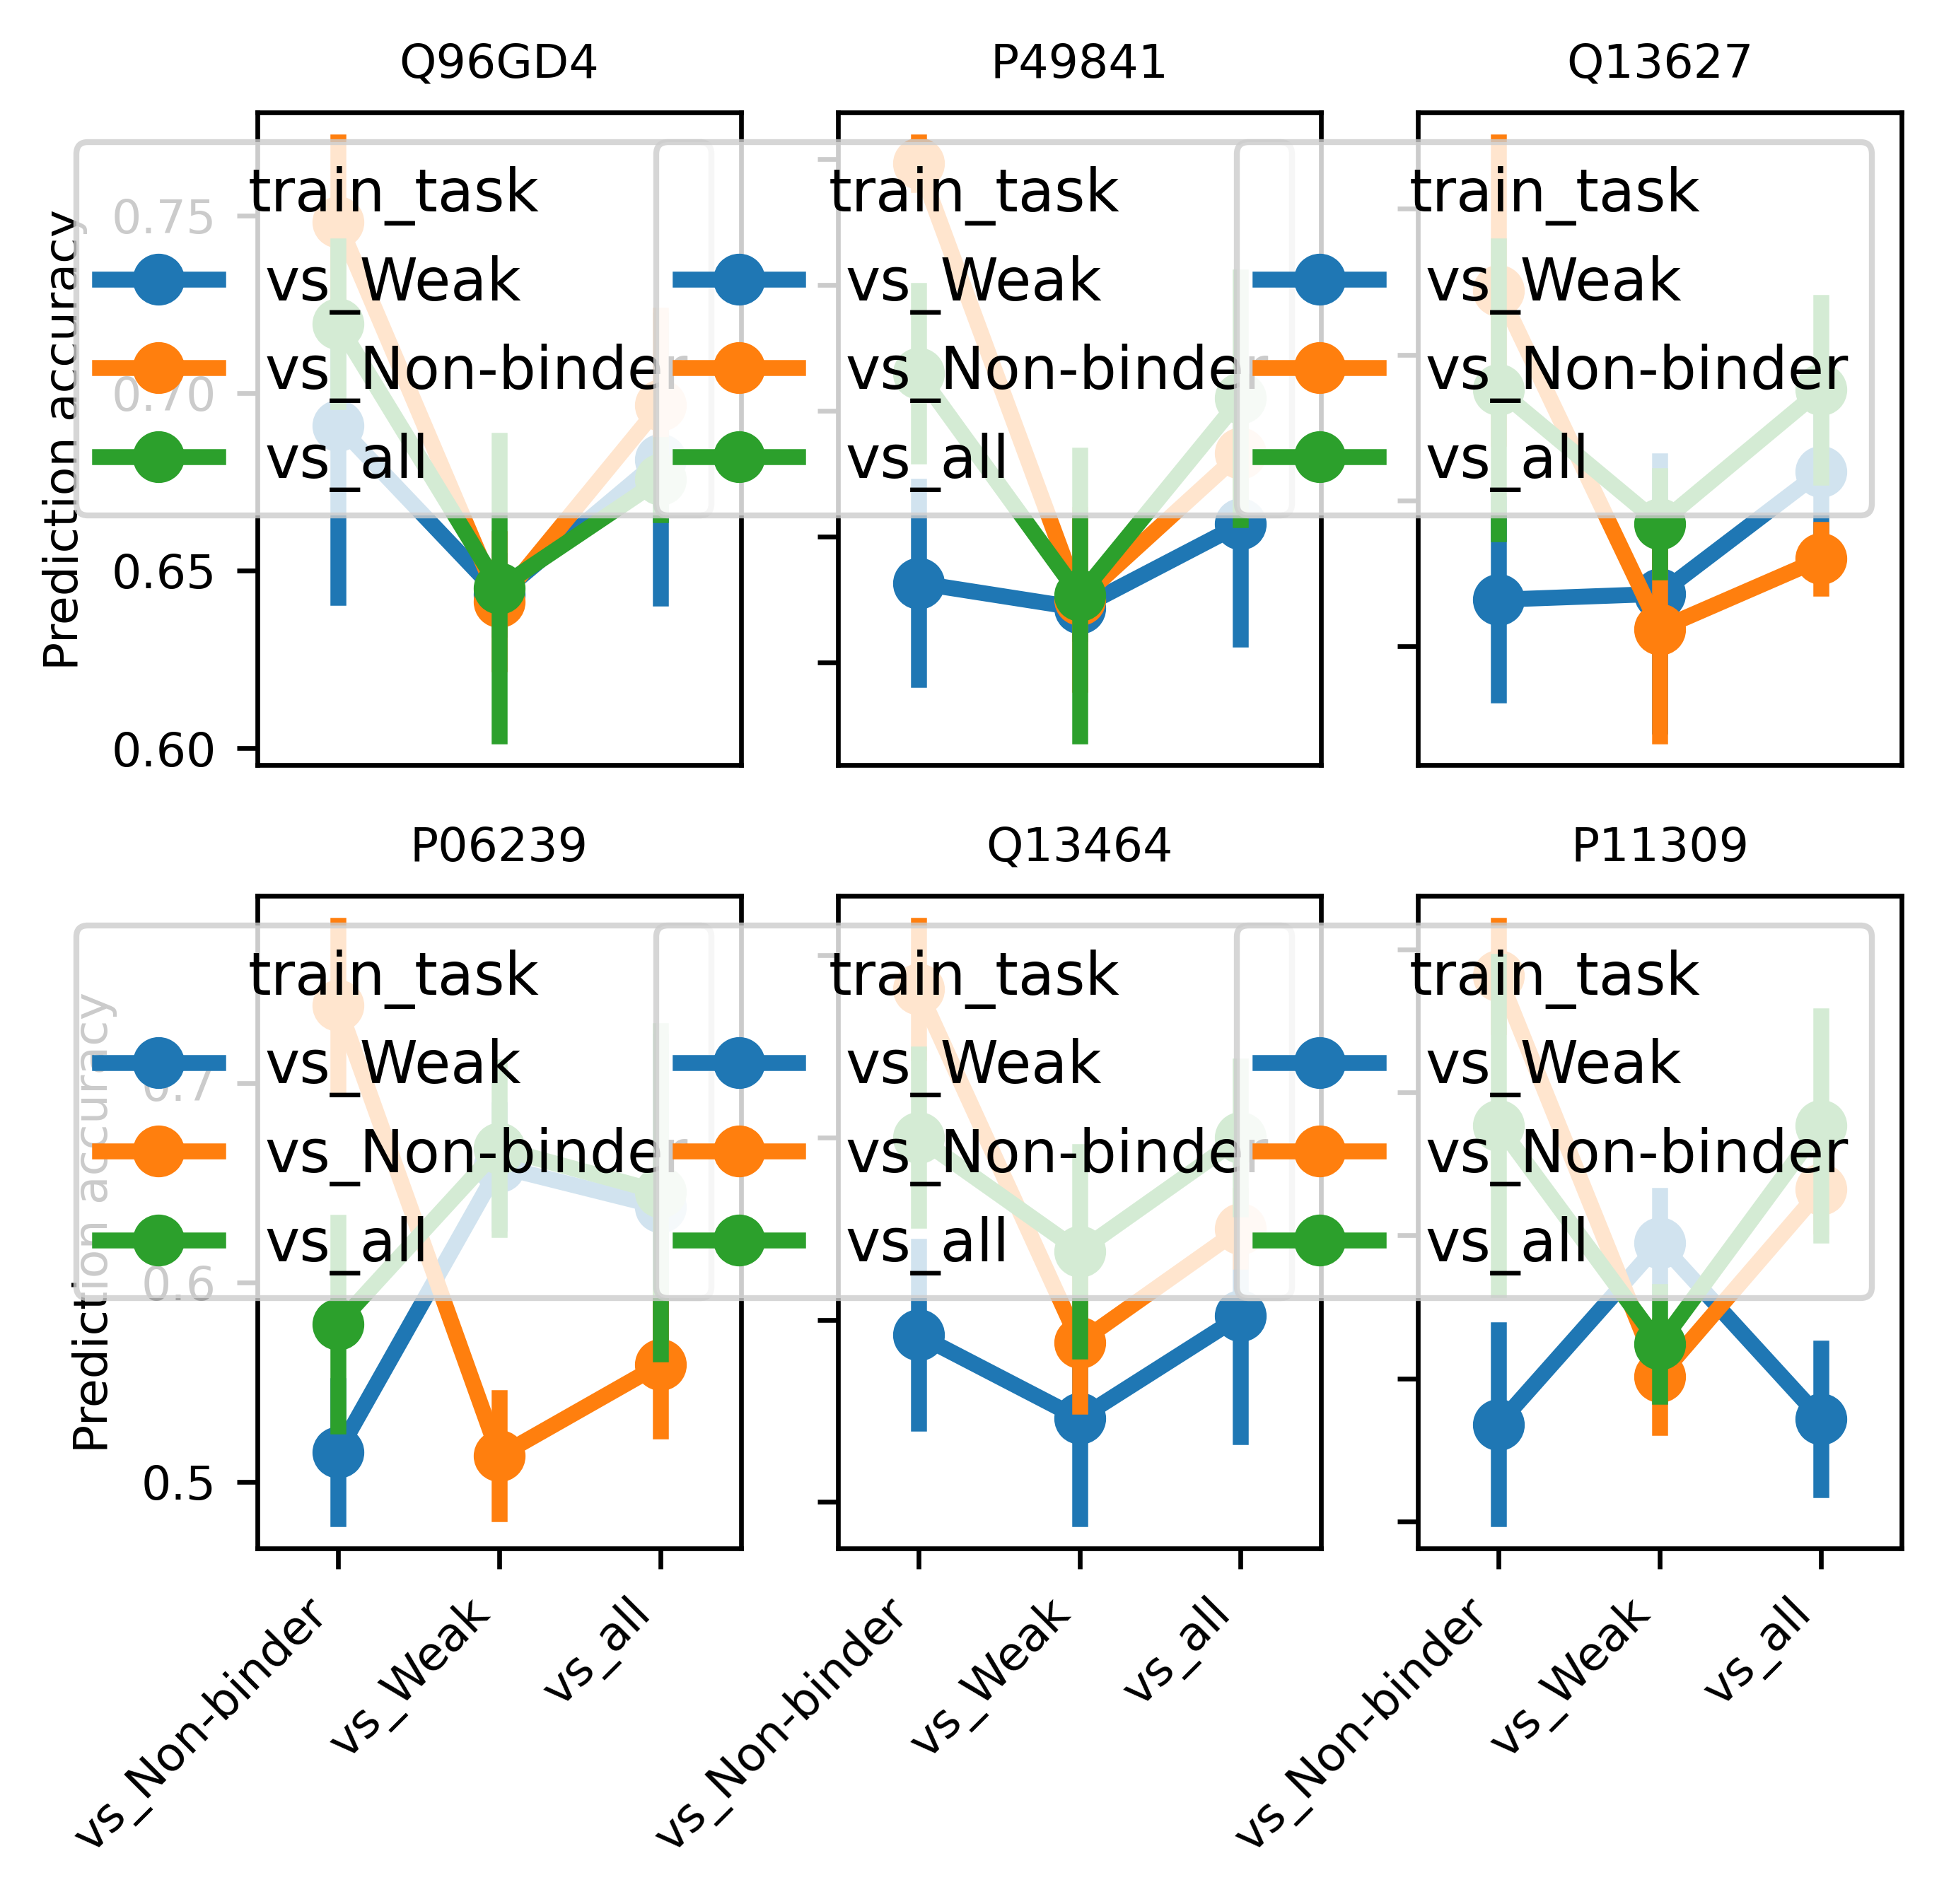

In [105]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(2.5 * 2, 1.4 * 3.14), dpi=600)

task_order = ["vs_Non-binder", "vs_Weak", "vs_all"]
#colors = [ '#ffa500','#0000ff','#008000']

for i, target in enumerate(targets_balanced_list):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    df_i = de_perf_all.query("target == @target")
    sns.pointplot(
        df_i,
        x="test_task",
        y="accuracy",
        order=task_order,
        hue="train_task",
        hue_order=["vs_Weak","vs_Non-binder", "vs_all"],
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{target}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)


In [ ]:
#also I can try mol2vec
#try simple models
#try GNN

In [21]:
input_dim = len(train_dataset['ChemBERTa_cls'].iloc[0])

In [22]:
ml.DNN(num_hidden_units=(9,5), input_dim=input_dim, activation_function="relu")

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=600, out_features=9, bias=True)
  (dropout_1): Dropout(p=0, inplace=False)
  (activation): ReLU()
  (linear_2): Linear(in_features=9, out_features=5, bias=True)
  (dropout_2): Dropout(p=0, inplace=False)
  (linear_3): Linear(in_features=5, out_features=1, bias=True)
  (final): Sigmoid()
)

In [33]:
batch_size = 32
learning_rate = 0.001
epochs = 100
optimizer_type = "Adam"
momentum = 0.9

X = np.array(train_dataset["ChemBERTa_cls"].tolist())
y = np.array(train_dataset["Y_binary"].tolist())

model = ml.DNN(num_hidden_units=(9,5), input_dim=input_dim, activation_function="relu", dropout_prob = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_tensor_val = torch.tensor(X_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_val = TensorDataset(X_tensor_val, y_tensor_val)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #we need to be able to change batch size
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

train_output = ml.train_for_ndb1(
                                epochs,
                                learning_rate,
                                train_loader=train_loader,
                                test_loader=val_loader,
                                model=model,
                                optimizer_type=optimizer_type,
                                momentum=momentum,
                                swa=True,
                                open_loader=None,) #we need to be able to change epochs

swa_model, model, online_metrics = train_output

acc = online_metrics[-1]["test_metrics"]["acc_closed"]

In [34]:
acc

0.5233644859813084

In [23]:
#The DNN models had a single hidden layer with 1000 units, and dropout 0.5. Learning rate and decay rate for the DNNs were selected with random hyperparameter search on the validation set. (65) 
batch_size = 32
learning_rate = 0.001
epochs = 100
optimizer_type = "Adam"
momentum = 0.9

X = np.array(train_dataset["ChemBERTa_cls"].tolist())
y = np.array(train_dataset["Y_binary"].tolist())

model = ml.SNN(num_hidden_units=1000, input_dim=input_dim, activation_function="relu", dropout_prob = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_tensor_val = torch.tensor(X_val, dtype=torch.float32)
y_tensor_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_val = TensorDataset(X_tensor_val, y_tensor_val)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #we need to be able to change batch size
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

train_output = ml.train_for_ndb1(
                                epochs,
                                learning_rate,
                                train_loader=train_loader,
                                test_loader=val_loader,
                                model=model,
                                optimizer_type=optimizer_type,
                                momentum=momentum,
                                swa=True,
                                open_loader=None,) #we need to be able to change epochs

swa_model, model, online_metrics = train_output

acc = online_metrics[-1]["test_metrics"]["acc_closed"]

In [24]:
acc

0.5607476635514018

Ok we will focus on BERT encding

In [108]:
test_dataset.shape

(134, 9)